In [3]:
import librosa
import pickle
import numpy as np

# Load their tuned model from file
with open("model/their_tuned_model.pkl", 'rb') as file:
    pickle_model = pickle.load(file)

# Load the standard scaler that was used to train their model
from joblib import load
scaler = load('model/std_scaler.bin')

instr_list = ["cel", "cla", "flu", "gac", "gel", "org", "pia", "sax", "tru", "vio", "voi"]

def score_prob_of_being(y, sr=44100, being=None, sim=False):
    rms = librosa.feature.rms(y=y)
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    to_append = f'{np.mean(rms)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'
    for e in mfcc:
        to_append += f' {np.mean(e)}'

    df = np.array([[float(x) for x in to_append.split(" ")]])
    
    X = scaler.transform(df)
    
    if being:
        mse = np.sqrt(np.mean(np.power(y - orig_y, 2))) if sim else 0
        return pickle_model.predict_proba(X)[0][instr_list.index(being)] - mse
    else:
        return pickle_model.predict_proba(X)[0]

In [21]:
songname = "dataset/IRMAS-TrainingData/tru/[tru][cla]1954__3.wav"
orig_y, sr = librosa.load(songname, sr=44100)
orig_y = np.real(librosa.istft(np.real(librosa.stft(orig_y))))
print("Probability of being what it actually is:", score_prob_of_being(orig_y, sr, "tru"))
tricked_class = "flu"
print("Probability of being what we want it to be:", score_prob_of_being(orig_y, sr, tricked_class))

Probability of being what it actually is: 0.9167229381044044
Probability of being what we want it to be: 0.011861473455462998


In [22]:
import numpy as np
from deap import base, creator, tools, algorithms

# Define the problem: Maximizing the fitness of the spectrogram
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", np.ndarray, fitness=creator.FitnessMax)

# Define the functions for initialization, mutation, crossover, and evaluation
def init_individual():
    y, sr = librosa.load(songname, sr=44100)
    return np.real(librosa.stft(y))

def mutate(individual, indpb):
    # Mutate an individual by adding a small random value to each element
    individual += np.random.normal(0, indpb, individual.shape)
    return individual,

def crossover(parent1, parent2):
    # Perform crossover by taking the average of corresponding elements
    return (parent1 + parent2) / 2,

def evaluate(individual):
    # Score the individual based on the probability of the model to predict it as what we want it to be
    return score_prob_of_being(np.real(librosa.istft(individual)), 44100, tricked_class, True),

# Set up the DEAP framework
toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, init_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", mutate, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

# Create an initial population
population_size = 25
population = toolbox.population(n=population_size)

# Run the evolution
generations = 50
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("max", np.max)
population, logbook = algorithms.eaMuPlusLambda(population, toolbox, mu=population_size, lambda_=population_size*2,
                                                cxpb=0.7, mutpb=0.2, ngen=generations, stats=stats, halloffame=None, verbose=True)

F:\sonic-subterfuge\venv\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
F:\sonic-subterfuge\venv\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	avg      	max      
0  	25    	0.0118615	0.0118615
1  	45    	0.0219821	0.0405167
2  	44    	0.0422872	0.064463 
3  	46    	0.0562209	0.0807555
4  	40    	0.0759119	0.113864 
5  	45    	0.101945 	0.157709 
6  	44    	0.117238 	0.169958 
7  	46    	0.1563   	0.240202 
8  	43    	0.179668 	0.240202 
9  	47    	0.206707 	0.246358 
10 	43    	0.225543 	0.246358 
11 	48    	0.235184 	0.247794 
12 	42    	0.242889 	0.247794 
13 	44    	0.246918 	0.247794 
14 	47    	0.245254 	0.247794 
15 	47    	0.247845 	0.24906  
16 	45    	0.247861 	0.24906  
17 	45    	0.247877 	0.24906  
18 	47    	0.247953 	0.24906  
19 	42    	0.248156 	0.24906  
20 	41    	0.248476 	0.24906  
21 	45    	0.248932 	0.249196 
22 	44    	0.249052 	0.249196 
23 	46    	0.249078 	0.249279 
24 	50    	0.2491   	0.249279 
25 	48    	0.249151 	0.249279 
26 	45    	0.249225 	0.249656 
27 	44    	0.249326 	0.249656 
28 	42    	0.249432 	0.249969 
29 	42    	0.249581 	0.249969 
30 	48    	0.24967  	0.249969 
31 	44  

In [23]:
# Access the best individual after evolution
best_individual = tools.selBest(population, k=1)[0]
best_fitness = best_individual.fitness.values[0]

print("Best Individual:", best_individual)
print(score_prob_of_being(np.real(librosa.istft(best_individual)), 44100))
print("Best Fitness:", best_fitness)

Best Individual: [[ 3.0699878   2.099763    0.58382034 ...  0.78692687  1.4172374
   2.067322  ]
 [-3.2918706  -0.4494158  -0.8173153  ... -0.2680538  -0.52396464
  -1.0366901 ]
 [ 2.9329844  -3.3226464  -0.7781012  ...  2.0047467   0.56365037
  -2.378638  ]
 ...
 [-0.1908182  -0.01180441  0.27741554 ... -0.05794505 -0.17381029
   0.05798903]
 [ 0.07090777 -0.02825404 -0.00605472 ... -0.04328731 -0.05358507
  -0.13023399]
 [-0.18830194 -0.08282848  0.04099537 ...  0.04379381  0.08402348
   0.02493672]]
[0.01624583 0.07377257 0.25142331 0.01503342 0.04519798 0.0549562
 0.03083457 0.10935244 0.32020321 0.05089524 0.03208522]
Best Fitness: 0.24989510856956143


In [24]:
from IPython.lib.display import Audio
from IPython.display import display

orig, sr = librosa.load(songname, sr=44100)
print(orig, sr)
modi = librosa.istft(best_individual)
display(Audio(data=orig, rate=sr))
display(Audio(data=modi, rate=sr))

[-0.1469574  -0.11343384 -0.08189392 ...  0.05056763  0.03649902
  0.02931213] 44100


In [25]:
import soundfile as sf
sf.write('out.wav', modi, sr)

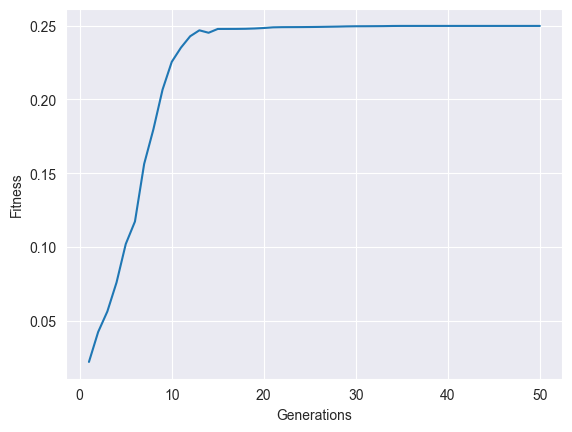

In [27]:
import matplotlib.pyplot as plt
plt.plot([x['gen'] for x in logbook[1:]], [x['avg'] for x in logbook[1:]])
plt.xlabel("Generations")
plt.ylabel("Fitness")
plt.show()